In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
print(mnist.keys())
X, y = mnist['data'], mnist['target']

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [2]:
X_less = X[:3000]
y_less = y[:3000]
print(X.shape, y.shape)

(70000, 784) (70000,)


In [3]:
import numpy as np
X_centered = X_less - X_less.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [6]:
pca.explained_variance_ratio_

array([0.09746116, 0.07155445])

In [7]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95  ) + 1

In [8]:
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X)

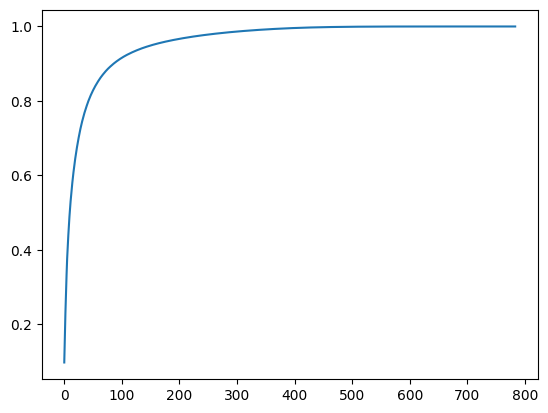

In [9]:
import matplotlib.pyplot as plt
plt.plot(cumsum)

In [10]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X)
X_recovered = pca.inverse_transform(X_reduced)

In [11]:
rnd_pca = PCA(n_components=154, svd_solver='randomized')
X_reduced = rnd_pca.fit_transform(X)

In [12]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X, n_batches):
  inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X)

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import KernelPCA

clf = Pipeline([
 ("kpca", KernelPCA(n_components=2)),
 ("log_reg", LogisticRegression())
 ])
param_grid = [{
 "kpca__gamma": np.linspace(0.03, 0.05, 10),
 "kpca__kernel": ["rbf", "sigmoid"]
 }]
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_less, y_less)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [14]:
grid_search.best_params_

{'kpca__gamma': 0.03, 'kpca__kernel': 'rbf'}

In [15]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
 fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X_less)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [17]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X_less, X_preimage)

4348.981457412106

In [18]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X_less)